# Detailed example

One-zone external field model of blazar PKS 0736+01, using the best-fit parameters from [Rodrigues et al 2023 (arXiv:2307.13024, see Tab. B1)](https://arxiv.org/abs/2307.13024)

In [43]:
import numpy as np
import pickle as pickle
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from astropy.constants import codata2010 as const
from matplotlib import pyplot as plt
import seaborn as sns

### Define source parameters
(implemented in AM3 in the next step)

In [29]:
rblob =      4.62e+16
tdyn = rblob / const.c.cgs.value
magfield =   7.83e-2
egammamin =  2.16e1
egammamax =  7.36e3
eindex =     2.02
elum =       1.84e+41
lorentz =    17.6
rdiss =      2.17e+17 # Dissipation radius in cm (cf Rodrigues+2023 Fig.2)
pgammamin =  1e2
pgammamax =  2.06e6
pindex =     1.0
plum =       6.29e+43

# Load useful constants and conversion factors
m_e_ev = (const.m_e * const.c ** 2).cgs.to(u.eV).value # electron mass [eV]

### Import the compiled AM3 core and set up the simulation

In [ ]:
import am3_pybind_core_hadronic as am3

rp = am3.RunParams()
# Set escape time scale (subject to switch below)
rp.t_esc = tdyn
# Set time scale of zone expansion (subject to switch below)
rp.t_expansion = tdyn
# Set solver time step
rp.dt = 3e-2 * tdyn

dat = am3.AM3Arrays()
ph = am3.PhysicsHandler(rp, dat)
sim = am3.SimulationManager(rp, ph)
io = am3.IO(sim, rp, dat)


### Set AM3 switches and initialize kernels

In [ ]:

# Input magnetic field strength [gauss]
# This must done before initializing the kernels
sim.Update_B(magfield)

sim.UpdateVerbosity(0)
sim.solver_ignoreCurrentLosses = 0
sim.solver_e = 5
# Manually define max proton and electron energy
sim.estimate_max_energies = 0
# Keep track of different components (only for plotting: set to 0 for efficiency)
sim.process_parse_sed = 1
# Hadronic processes on
sim.process_hadronic = 1
# Keep track of positrons and electrons separately
sim.process_mergePositronsIntoElectrons = 0

# Injection and escape (see documantation)
sim.process_es = 1
sim.escape_type = 2
sim.process_es_photonOptThick = 0
sim.process_in = 0
sim.internal_inj_type = 2 
sim.process_inext = 1
# Expansion of radiation zone (see documantation)
sim.process_exp = 0
sim.process_adi = 1
# Synchrotron emission from different particles (all on)
sim.process_esy = 1
sim.process_esyrad = 1
sim.process_esycool = 1
sim.process_qsyn = 0
sim.process_ssa = 1
sim.process_psy = 1
sim.process_psyrad = 1
sim.process_psycool = 1
sim.process_musy = 1
sim.process_musyrad = 1
sim.process_musycool = 1
sim.process_pisy = 1
sim.process_pisyrad = 1
sim.process_pisycool = 1
# Inverse Compton from different particles (all on)
sim.process_eic = 1
sim.process_eicrad = 1
sim.process_eicrad_fast = 1 
sim.eicrad_fast_n_photon_in = 2
sim.eicrad_fast_n_photon_out = 2
sim.eicrad_fast_photon_in_max = 280
sim.eicrad_fast_photon_out_min = 100
sim.process_eiccool = 1
sim.process_eic_photonLoss = 1
sim.process_pic = 1
sim.process_picrad = 1
sim.process_piccool = 1
sim.process_muic = 1
sim.process_muicrad = 1
sim.process_muiccool = 1
sim.process_piic = 1
sim.process_piicrad = 1
sim.process_piiccool = 1
# Secondary particle decay
sim.process_sec_decay = 1
sim.process_pi_decay = 1
sim.process_mu_decay = 1
# Pair production (gamma gamma -> e- e+)
sim.process_pair = 1
sim.process_pair_photonLoss = 1
sim.process_pair_feedback = 1
sim.process_pair_feedback_8bin = 1
# Bethe-Heitler pair production (p gamma -> p e+ e-)
sim.process_bh = 0
sim.process_bhrad = 1
sim.process_bhrad_fast = 1
sim.bhrad_fast_n_el_out = 2
sim.bhrad_fast_proton_in_min = 70
sim.bhrad_fast_photon_in_max = 280
sim.process_bhcool = 1
# Photo-pion production (nucleon gamma -> nucleon pion)
sim.process_pg = 1
sim.process_pgrad = 1
sim.process_pgrad_fast = 0
sim.pgrad_fast_n_photon_in = 2
sim.pgrad_fast_photon_in_max = 280
sim.process_pgcool = 1
sim.process_pg_photonLoss = 1

# Finally, initialize the kernels
sim.InitKernels()
sim.Clear_Particles()


### Define accelerated electron spectrum and inject it

In [ ]:
# Create spectrum, in this case a simple power law

# Proton lorent factor grid
egammagrid = io.E_LepE_eV() / (const.m_e * const.c ** 2).to(u.eV)
epowerlaw = (egammagrid ** (1 - eindex) 
                * (egammagrid >= egammamin) 
                * np.exp(-egammagrid/egammamax)
            )
# Integrate spectrum in erg/s
etrapz = np.trapz(epowerlaw, egammagrid) * (const.m_e * const.c ** 2).cgs.value 
# Normalize it to the desired proton lumiosity
enormalized = epowerlaw * elum / etrapz # erg/s
# Convert it to an energy density injection rate
enormalized /= 4./3 * np.pi * rblob ** 3 # erg/cm3/s
# And finally to a particle density injection rate
enormalized /= egammagrid * (const.m_e * const.c ** 2).cgs.value # cm-3.s-1
# Inject spectrum in the simulation
io.set_Edn_dEdt_ext_LepE(enormalized)

### Define accelerated proton spectrum and inject it

In [ ]:
# Create spectrum, in this case a simple power law

# Proton lorent factor grid
pgammagrid = io.E_Had_eV() / (const.m_p * const.c ** 2).to(u.eV)
ppowerlaw = (pgammagrid ** (1 - pindex) 
                * (pgammagrid >= pgammamin) 
                * np.exp(-pgammagrid/pgammamax)
            )
# Integrate spectrum in erg/s
ptrapz = np.trapz(ppowerlaw, pgammagrid) * (const.m_p * const.c ** 2).cgs.value 
# Normalize it to the desired proton lumiosity
pnormalized = ppowerlaw * plum / ptrapz # erg/s
# Convert it to an energy density injection rate
pnormalized /= 4./3 * np.pi * rblob ** 3 # erg/cm3/s
# And finally to a particle density injection rate
pnormalized /= pgammagrid * (const.m_p * const.c ** 2).cgs.value # cm-3.s-1
# Inject spectrum in the simulation
io.set_Edn_dEdt_ext_HadP(pnormalized)

### Define external photon spectrum and inject it

In this case we consider three components (see Fig. 2 of [Rodrigues+ 2023](https://arxiv.org/abs/2307.13024)):
    
- Broad lines from hydrogen and helium Lymann alpha emission
- Fraction of the thermal disk emission scattered in the BLR
  (following a multi-temperature Shakura-Sunaev spectrum)
- Infrared emission from a dust torus 
  (following a simple black-body spectrum)

Below we define arrays with the spectral shapes of these different components, normalize them to the disk luminosity including the respective covering factors, boost them into the jet rest frame, add them up into a single array, and finally inject this in the simulation as external photons.

In [ ]:
def PlanckDistribution(earr, temperature, lum):
    '''
    Thermal Distribution (unnormalized)

    return: E^2dN/dE [a.u.]
    par earr (array): photon energy [eV]
    par temperature [K]
    par lum: total luminosity [erg/s]
    '''
    lgr = earr / temperature / const.k_B.to(u.eV/u.K)
    exparr = np.exp(lgr) - 1
    ednde = earr ** 4 / exparr
    integ = np.trapz(ednde / earr, earr)
    return ednde * lum / integ

def DiskTemperature(rad, lumdisk, m_bh, eta=0.08):
    '''Radius-dependent disk temperature [K]
    '''
    sb = const.sigma_sb.to(u.erg/u.s/
                           u.K**4/u.cm**2)
    rsch = Schwarzschild(m_bh)
    
    term1 = 3 * rsch * lumdisk / (16 * np.pi * eta 
                                  * sb * rad ** 3)
    term2 = 1 - (3 * rsch / rad) ** 0.5
    return (term1 * term2) ** 0.25
 

def ShakuraFlux(earr, lumdisk, m_bh, thetaobs=3.0, eta=0.08):
    '''Disk spectral flux in observer's frame [erg/cm2/s]
    
    earr (array): photon energies [eV]
    lumdisk: [erg/s]
    m_bh: black hole mass / m_solar
    thetaobs: angle btw. LOS and disk rotation axis (deg)
    '''
    kB = const.k_B.to(u.eV/u.K)
    c0 = const.c.cgs
    hplanck = const.h.to(u.eV*u.s)
#     dlum = cosmo.luminosity_distance(z).to(u.cm)
    rsch = Schwarzschild(m_bh)
    rin = 3 * rsch
    rout = 300 * rsch
    radarr = np.linspace(rin, rout, 50)
    
    frac = (4 * np.pi) ** 2 * hplanck * np.cos(thetaobs*np.pi/180) / c0 ** 2
    nuarr = earr / hplanck       # convert x-axis to obs frame
    en2d = earr[:,np.newaxis]    # convert x-axis to obs frame
    rad2d = radarr[np.newaxis,:]
    temp2d = DiskTemperature(rad2d,lumdisk,m_bh,eta) # K
    
    integrand = rad2d / (np.exp(en2d/temp2d/kB) - 1)
    integral = np.trapz(integrand, radarr, axis=1)
    Fnu = (nuarr ** 3 * frac * integral).to(u.erg)
    return nuarr * Fnu

def BroadLine(earr, center, width, lum):
    '''
    Broad line spectrum, normalized to `lum` 

    return: E^2dN/dE [a.u.]
    par earr (array): photon energies (eV)
    par center: line energy [eV]
    par width: line width (eV)
    par lum: line luminosity [erg/s]
    '''
    ednde = np.exp(-0.5 
                   * (earr - center) ** 2 
                   / width ** 2
                  )
#     ednde[ednde < 1e-100] = 0.
    integ = np.trapz(ednde/earr, earr)
    ednde *= lum / integ
    return ednde

def get_BLR_density_scaling(R_zone, R_diss, lorentz):
    '''Scaling of the photon density seen in the jet frame 
    with the dissipation radius, according to Eq. 20 of 
    Ghisellini+Tavecchio 0902.0793
    '''

    def scaling_for_large_R_diss(R_diss, R_zone, lorentz):
        beta = (1 - 1. / lorentz ** 2) ** 0.5
        mu1 = (1 + (R_zone / R_diss) ** 2) ** -.5
        mu2 = (1 - (R_zone / R_diss) ** 2) ** .5
        f_mu = (2 * (1 - beta * mu1) ** 3
                - (1 - beta * mu2) ** 3
                - (1 - beta) ** 3)
        return f_mu / 3. / beta

    f0 = 17. / 12
    
    if R_diss <= R_zone:
        scaling = f0
        
    elif R_diss >= 3 * R_zone:
        scaling = scaling_for_large_R_diss(
            R_diss,
            R_zone,
            lorentz)
        
    elif R_zone < R_diss < 3 * R_zone:
        # Power-law interpolation
        f_3R = scaling_for_large_R_diss(
            3 * R_zone, 
            R_zone,
            lorentz
        )
        scaling = 10 **(
            (np.log10(f_3R) - np.log10(f0))
            / (np.log10(3 * R_zone) - np.log10(R_zone))
            * (np.log10(R_diss) - np.log10(R_zone))
        )
        
    return scaling
     
def tangential_angle(R_BLR, R_diss):
    '''Calculate the characteristic angle of the radiaiton,
        which is the tangential angle. This is where the dominant
        contribution comes from because it has the highest doppler
        boost, as well as for geometric reasons.
    '''
    csi = np.arcsin(R_BLR/R_diss)
    return csi

def calc_doppler(lorentz, R_BLR, R_diss):
    '''Calculate relative Doppler factor between blob and BLR.
        The blob has bulk factor `lorentz` and distance to the black hole 
        given by `R_diss` [cm]. The BLR has radius `R_BLR` [cm].
    '''
    if R_diss <= R_BLR:
        return lorentz
         
    csi = tangential_angle(R_BLR, R_diss)
    beta = (1 - 1. / lorentz ** 2) ** 0.5
    doppler = lorentz * (1 - beta * np.cos(csi))
    return doppler

def convert_lum_to_density_in_jet(R_diss, lorentz, R_BLR):
        ''' Convert external field luminosity in the rest frame of the 
        black hole in [erg/s] into energy density in the comoving frame 
        of the jet blob in [GeV / cm^3]. R_BLR can represent the BLR radius
        or the dust torus radius. 

        return: conversion factor [GeV erg^-1 s cm^-3]
        '''      

        doppler_fact = calc_doppler(lorentz, R_BLR, R_diss)
        
        f1 = (doppler_fact ** 2 
                / (4.
                    * np.pi 
                    * R_BLR ** 2 
                    * const.c.cgs.value)
                * u.erg.to('GeV'))
                
        f2 = get_BLR_density_scaling(R_BLR, R_diss, lorentz)
        factor =  f1 * f2 
        
        return factor


# Define BLR and torus parameters

disk_lum =  1e45 * u.erg/u.s
black_hole_mass = 6e8 # [solar mass units]
blr_radius = 9.87e+16 # [cm]
torus_radius = 2.5e18 # [cm]

torus_temperature = 500 * u.K
blr_covering, torus_covering = 0.1, 0.3

blr_doppler = calc_doppler(lorentz, blr_radius, rdiss)
torus_doppler = calc_doppler(lorentz,torus_radius,rdiss)

# AM3 photon grid
egrid_jetframe = io.E_LepG_eV() * u.eV 
# Set up array for adding up external fields
external_photons = np.zeros(egrid_jetframe.size) * u.GeV / u.cm**3

# Scattered thermal disk emission
disky = ShakuraFlux(egrid_jetframe / blr_doppler, 
                    disk_lum, 
                    black_hole_mass, 
                    3.0) # erg/s, black hole frame

# Broad line emission
hybl = BroadLine(egrid_jetframe / blr_doppler, 
                    10.2*u.eV, 10.2*u.eV/20, 
                    disk_lum * blr_covering) # H Ly alpha [erg/s]
hebl = BroadLine(egrid_jetframe / blr_doppler, 
                    40.8*u.eV, 40.8*u.eV/20, 
                    disk_lum * blr_covering * 0.5) # He Ly alpha [erg/s]
# Convert BLR components to jet frame
blr_to_jet = convert_lum_to_density_in_jet(rdiss,lorentz,blr_radius) # erg/s -> GeV/cm3 
blr_to_jet *= u.GeV / u.cm ** 3 / (u.erg / u.s) # give it units

external_photons += (disky * 0.01 + 
                     hybl + 
                     hebl
                     ) * blr_to_jet # GeV/cm3

# Dust torus
torusy = PlanckDistribution(egrid_jetframe / torus_doppler,
                            torus_temperature,
                            disk_lum * torus_covering) # [erg/s]  
# Convert torus emission to jet frame
tor_to_jet = convert_lum_to_density_in_jet(rdiss,lorentz,torus_radius) # erg/s -> GeV/cm3 
tor_to_jet *= u.GeV / u.cm**3 / (u.erg/u.s)  # give it units
# Add torus to BLR components 
external_photons += torusy * tor_to_jet

# Convert summed up components from energy density to particle density injection rate in jet frame
spect = (external_photons / egrid_jetframe).to(u.cm ** -3) / (tdyn * u.s) # cm-3.s-1

# Inject external photon fields into simulation (see function docstring in IO.h)
sim.set_Edn_dE_LepG(spect.value)



### Run simulation

In [ ]:
electron_time_evol = []
proton_time_evol = []
photon_time_evol = []
neutrino_time_evol = []

time = 0
while time < 3 * rp.tdynco: # Run up to 3x the light-crossing time 
    sim.EvolveStep() # Evolve solver
    time += rp.FRACt * rp.tdynco # Count time

    # Save particle arrays to plot time evolution
    # (not necessary for steady-state calculation)
    electron_time_evol.append(dat.get_LepE() * const.sigma_T.cgs.value ** -1.5)
    proton_time_evol.append(dat.get_HadP())
    photon_time_evol.append(dat.get_LepG1() * const.sigma_T.cgs.value ** -1.5)
    neutrino_time_evol.append(dat.get_NUe()+
                              dat.get_NUeA()+
                              dat.get_NUm()+
                              dat.get_NUmA())

## Plot steady-state emission

/Users/xrodrigu/anaconda3/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/xrodrigu/anaconda3/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


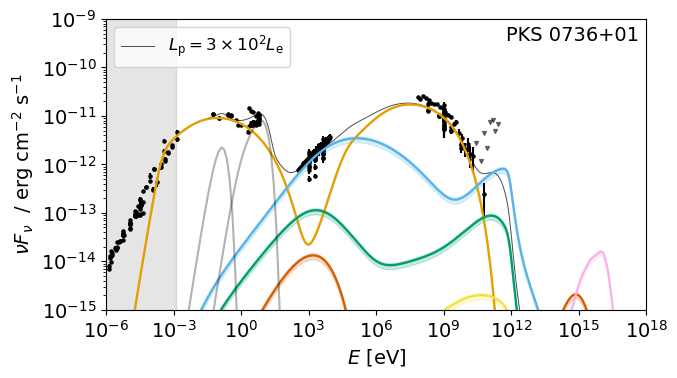

In [ ]:
# Conversion to observer's frame

z = 0.19

# GeV, jet frame -> eV, obs. frame
energy_conversion = 1e9 * lorentz / (1 + z) 

# GeV/cm3, source frame -> erg/cm2/s, obs. frame
lum_dist = cosmo.luminosity_distance(z).cgs.value
density_to_lum = 4 * np.pi * rblob ** 2 * const.c.cgs.value
lum_to_flux = 1./(4 * np.pi * lum_dist ** 2)
spectrum_conversion = density_to_lum * lum_to_flux * lorentz ** 4

# Energy arrays in source frame
egrid_pho = io.E_LepG_eV() * u.eV.to(u.GeV) 
egrid_nu = io.E_HadP_eV() * u.eV.to(u.GeV) 

# Get individual SED components

BINX = egrid_pho.size
totp = CAT[s].params['best_fit']['components_best'][BINX*0 : BINX*1]
insy = CAT[s].params['best_fit']['components_best'][BINX*1 : BINX*2]
inic = CAT[s].params['best_fit']['components_best'][BINX*2 : BINX*3]
bhsy = CAT[s].params['best_fit']['components_best'][BINX*3 : BINX*4]
bhic = CAT[s].params['best_fit']['components_best'][BINX*4 : BINX*5]
ppsy = CAT[s].params['best_fit']['components_best'][BINX*5 : BINX*6]
ppic = CAT[s].params['best_fit']['components_best'][BINX*6 : BINX*7]
pgsy = CAT[s].params['best_fit']['components_best'][BINX*7 : BINX*8]
pgic = CAT[s].params['best_fit']['components_best'][BINX*8 : BINX*9]
pi0 = CAT[s].params['best_fit']['components_best'][BINX*9 : BINX*10]
psy = CAT[s].params['best_fit']['components_best'][BINX*10 : BINX*11]
pic = CAT[s].params['best_fit']['components_best'][BINX*11 : BINX*12]


# Create plot
_ = plt.figure(figsize=(7,4))

mycolors = np.array([np.array([230,159,  0.]),
                     np.array([ 86,180,233.]),
                     np.array([  0,158,115.]),
                     np.array([240,228, 66.]),
                     np.array([  0,114,178.]),
                     np.array([213, 94,  0.]),
                     np.array([201,121,176.])])
mycolors *= 1./255

# Plot total SED
plt.loglog(egrid_pho * energy_conversion, # obs frame, GeV
           io.Edn_dE_LepG1() * egrid_pho * spectrum_conversion, # obs frame, erg/cm2/s
           lw=0.7, c='k')

# Plot all-flavor neutrino spectrum
plt.loglog(egrid_nu * energy_conversion, # obs frame, GeV
           io.Edn_dE_NU() * egrid_nu * spectrum_conversion,
           lw=1.7, color=sns.color_palette("colorblind",12)[6])

# Plot components
plt.loglog(egrid_pho, 
            insy + inic,
            c=mycolors[0],
            lw=1.7,
            label=r'e$^{-}$ synchrotron')
plt.loglog(egrid_pho, 
            bhsy + bhic,
            c=mycolors[1],
            lw=1.7,
            label=r'p$\gamma\rightarrow$pe$^+$e$^-$ synchrotron')
plt.loglog(egrid_pho, 
            ppsy + ppic,
            c=mycolors[2],
            lw=1.7,
            label=r'$\gamma\gamma\rightarrow$e$^+$e$^-$ synchrotron')
plt.loglog(egrid_pho, 
            pgsy + pgic,
            c=mycolors[3],
            lw=1.7,
            label=r'p$\gamma\rightarrow\pi\rightarrow\mu\rightarrow$e synchrotron')
plt.loglog(egrid_pho, 
            psy + pic,
            c=mycolors[5],
            lw=1.7,
            label='p synchrotron')
plt.loglog(egrid_pho, 
            pi0,
            c='gray', 
            ls=':',lw=1.7,
            label=r'$\pi^0\rightarrow\gamma\gamma$')

 
# Plot thermal emission
ethermal = np.logspace(-3,3,50)
eobs = ethermal / (1 + z)
disk = ShakuraFlux(ethermal * u.eV, 
                    disk_lum * u.erg/u.s,
                    black_hole_mass
                    ) * lum_to_flux

torus = PlanckDistribution(ethermal * u.eV,
                            500 * u.K,
                            disk_lum * torus_covering * u.erg/u.s
                            ) * lum_to_flux

plt.loglog(eobs, disk, color='gray',lw=1.0)
plt.loglog(eobs, torus, color='gray',lw=1.0)
    

plt.xlabel(r"$E$ [eV]")
plt.ylabel(r"$\nu F_\nu$  / erg cm$^{-2}$ s$^{-1}$")
plt.axis([1e-6,1e18,1e-15, 1e-9])

plt.annotate("PKS 0736+01", 
             (5e17,3.5e-10), 
             fontsize=14, 
             horizontalalignment='right')

plt.legend(loc=(-0.1,-0.55), fontsize=13,frameon=1,ncol=3)

plt.tight_layout()
    
plt.show()
